In [1]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
NE0=250 # number of cells in horizontal direction
NE1=250 # number of cells in vertical direction
h0=150. # in horizontal meter [m] grid spacing
h1=150. # in vertical meter [m] grid spacing


In [3]:
L0, L1=NE0*h0, NE1*h1

In [4]:
from esys.escript import *
from esys.finley import Rectangle
domain=Rectangle(l0=L0, l1=L1, n0=NE0, n1=NE1)

In [5]:
H_data=25000

In [6]:
surface_z=int(H_data/h1)*h1
surface_z+h1/2,L1

(24975.0, 37500.0)

True conductivity distribution:

In [7]:
sigma1=2
sigma_bg=0.01

D=300
D=500
H=2000+2000
W=1000
OFFSET=500

In [8]:
X=ReducedFunction(domain).getX()
m1=whereNonPositive(X[1]-(surface_z-D))
m2=whereNonNegative(X[1]-(surface_z-D-H))
m3=whereNonNegative(X[0]-(L0/2+OFFSET-W/2))
m4=whereNonPositive(X[0]-(L0/2+OFFSET+W/2))
m=m1*m2*m3*m4
sigma_true=(m*sigma1+(1-m)*sigma_bg)*whereNonPositive(X[1]-surface_z)

Text(0, 0.5, '$x_1$ [m]')

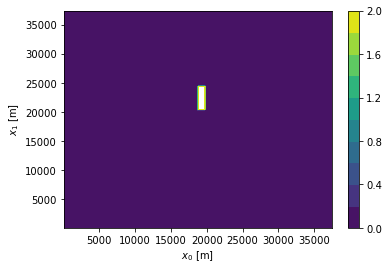

In [9]:
sigma_np=convertToNumpy(sigma_true) 
X_np=convertToNumpy(X)

plt.figure()
contour=plt.tricontourf(X_np[0], X_np[1], sigma_np[0], 10)
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')

In [10]:
m_data=whereNegative(abs(X[1]-(surface_z+h1/2))-h1/2)*whereNegative(abs(X[0]-L0/2)-L0*0.45)

Text(0, 0.5, '$x_1$ [m]')

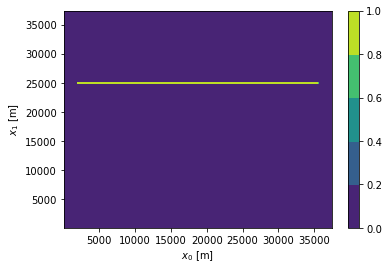

In [11]:
plt.figure()
contour=plt.tricontourf(X_np[0], X_np[1], convertToNumpy(m_data)[0], 5)
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')

Get the test data and add some noise:

In [12]:
from mytools import getMTTE, InversionMTTE, Mu0

In [13]:
f=10
f=5
data=getMTTE(domain, f, sigma_true)

In [14]:
data*=(1+0.02*(2*RandomData((), data.getFunctionSpace())-1))

 set `Wd`:

In [15]:
Wd=interpolate(m_data, Function(domain))
Wd/=integrate(Wd)
Wd*=1/abs(0.05*abs(data))**2

Define the cost function:
reference is only non-zero in the subsurface

In [16]:
sigma_ref=sigma_bg*whereNonPositive(X[1]-surface_z)

In [17]:
cf=InversionMTTE(domain, f, data, Wd, z_surface=surface_z, sigma_ref=sigma_ref, mu=1.e-2)

In [1]:
import logging
mylogger = logging.getLogger('esys')
mylogger.setLevel(logging.DEBUG)

In [2]:
from esys.escript.minimizer import MinimizerLBFGS
solver=MinimizerLBFGS(J=cf, m_tol=1e-3, J_tol=None, imax=500, logger=mylogger)
solver.setOptions(truncation=25, restart=60)
m=Scalar(0., Solution(domain))
solver.run(m)
mi=solver.getResult()

SyntaxError: invalid syntax (47443676.py, line 2)

In [19]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


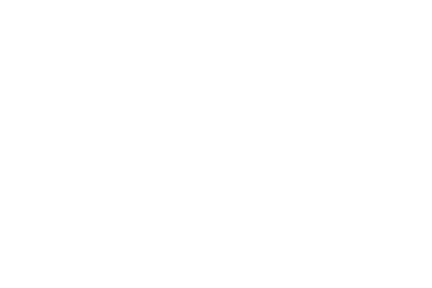

Text(0, 0.5, '$x_1$ [m]')

In [20]:
sigma=cf.sigma_ref*exp(mi)
sigma_np=convertToNumpy(sigma)
x_np=convertToNumpy(sigma.getX())
plt.figure()
contour=plt.tricontourf(x_np[0], x_np[1], sigma_np[0], 20)
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')

In [21]:
from esys.escript.pdetools import Locator
x0_transect=np.linspace(h0/2, L0-h0/2, NE0)
x_transect=[ (x0, surface_z+h1/2) for x0 in np.linspace(L0/2-L0*0.45, L0/2+L0*0.45, int(NE0*0.9)) ]
transect_locator=Locator(where=ReducedFunction(domain), x=x_transect )
x0_transect=[ x[0] for x in transect_locator.getX() ]

In [22]:
data_transect=transect_locator.getValue(1./(cf.omega*Mu0)*abs(data)**2)

In [23]:
datai=getMTTE(domain, f, sigma)
datai_transect=transect_locator.getValue(1./(cf.omega*Mu0)*abs(datai)**2)

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x0_transect, data_transect, label="input", s=1)
plt.plot(x0_transect, datai_transect, label="recovered")
plt.xlabel('offset [m]')
plt.ylabel('rho_a')
plt.legend()
plt.title("apparent resistivity over transect @ height %g m"%(transect_locator.getX()[0][1]))

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'apparent resistivity over transect @ height 24975 m')